In [613]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [614]:
import GArDen.interfaces as garden
from GArDen.convert.sequence import SeqToPathGraph
from GArDen.transform.rna_structure import PathGraphToRNAPlfold

def remap_with_structure(pos_seqs):
    graphs = garden.transform(pos_seqs, program=SeqToPathGraph())
    graphs = garden.transform(graphs, program=PathGraphToRNAPlfold(max_num_edges=2,
                                                                   window_size=200,
                                                                   max_bp_span=100,
                                                                   hard_threshold=.5,
                                                                   avg_bp_prob_cutoff=.01))
    remap={'A0':'A','C0':'C','G0':'G','U0':'E','T0':'E',
           'A1':'V','C1':'S','G1':'Y','U1':'D','T1':'D'}
    for graph in graphs:
        paireds = [graph.node[u]['label']+str(int(graph.node[u].get('paired',False))) for u in graph.nodes()]
        paireds = [remap[c] for c in paireds]
        seq = ''.join(paireds)
        yield ('ID',seq)
alphabet = 'protein'
color_scheme = 'chemistry'

In [615]:
def remap_with_structure(pos_seqs):
    for seq in pos_seqs:
        yield seq
alphabet = 'rna'
color_scheme = 'classic'

In [616]:
def filter_pvalue(iterable, pval_threshold=8.7, less_than=False):
    for header,seq in iterable:
        pval = float(header.split('_')[1])
        if less_than:
            if pval < pval_threshold:
                yield (header,seq)
        else:
            if pval > pval_threshold:
                yield (header,seq)

In [617]:
pos_fname = 'FMR1_bin_sites.fa'
pos_fname = 'FMR1_predicted_bin_sites.fa'
complexity=3
n_clusters=20
min_subarray_size = 5
max_subarray_size = 10
block_size = 500

In [618]:
from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)

pos_seqs = filter_pvalue(pos_seqs)
from eden.util import iterator_size
print 'Processing %d sequences' % iterator_size(pos_seqs)

Processing 15140 sequences


In [619]:
from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs)
pos_seqs = remap_with_structure(pos_seqs)
#neg_seqs = fasta_to_sequence(neg_fname)

In [620]:
from eden.converter.fasta import fasta_to_sequence
neg_seqs = fasta_to_sequence(pos_fname)
neg_seqs = filter_pvalue(neg_seqs)
neg_seqs = remap_with_structure(neg_seqs)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(neg_seqs, modifier=shuffle_modifier, times=1, order=2)

In [621]:
%%time
from eden.eden_motif import SequenceMotifDecomposer
m=SequenceMotifDecomposer(complexity=complexity,
                          n_clusters=n_clusters,
                          min_subarray_size=min_subarray_size,
                          max_subarray_size=max_subarray_size,
                          pos_block_size=block_size,
                          neg_block_size=block_size)
m.fit(pos_seqs, neg_seqs)

Setup 9.04 secs
0 (1000, 1048577) (35.97 secs) (delta: 35.97)
1 (1000, 1048577) (36.28 secs) (delta: 0.31)
2 (1000, 1048577) (48.39 secs) (delta: 12.11)
3 (1000, 1048577) (49.16 secs) (delta: 0.77)
4 (1000, 1048577) (49.23 secs) (delta: 0.07)
5 (1000, 1048577) (49.31 secs) (delta: 0.08)
6 (1000, 1048577) (49.71 secs) (delta: 0.40)
7 (1000, 1048577) (49.75 secs) (delta: 0.03)
8 (1000, 1048577) (49.78 secs) (delta: 0.03)
9 (1000, 1048577) (50.17 secs) (delta: 0.39)
10 (1000, 1048577) (62.61 secs) (delta: 12.44)
11 (1000, 1048577) (63.50 secs) (delta: 0.88)
12 (1000, 1048577) (63.54 secs) (delta: 0.05)
13 (1000, 1048577) (63.58 secs) (delta: 0.04)
14 (1000, 1048577) (64.06 secs) (delta: 0.48)
15 (1000, 1048577) (64.16 secs) (delta: 0.09)
16 (1000, 1048577) (64.24 secs) (delta: 0.08)
17 (1000, 1048577) (64.62 secs) (delta: 0.38)
18 (1000, 1048577) (78.02 secs) (delta: 13.40)
19 (1000, 1048577) (78.74 secs) (delta: 0.72)
20 (1000, 1048577) (78.78 secs) (delta: 0.04)
21 (1000, 1048577) (78.9

In [622]:
%%time
from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs)
pos_seqs = remap_with_structure(pos_seqs)
clusters = m.predict(pos_seqs)

Setup 6.12 secs
0 (50.22 secs) (delta: 50.22)
1 (52.36 secs) (delta: 2.14)
2 (52.36 secs) (delta: 0.00)
3 (53.89 secs) (delta: 1.53)
4 (53.89 secs) (delta: 0.00)
5 (53.89 secs) (delta: 0.00)
6 (54.10 secs) (delta: 0.20)
7 (54.10 secs) (delta: 0.00)
8 (112.18 secs) (delta: 58.08)
9 (114.57 secs) (delta: 2.40)
10 (114.58 secs) (delta: 0.00)
11 (115.09 secs) (delta: 0.51)
12 (115.45 secs) (delta: 0.36)
13 (115.80 secs) (delta: 0.35)
14 (117.26 secs) (delta: 1.46)
15 (117.98 secs) (delta: 0.72)
16 (173.97 secs) (delta: 55.99)
17 (174.79 secs) (delta: 0.82)
18 (177.34 secs) (delta: 2.54)
19 (177.34 secs) (delta: 0.00)
20 (177.34 secs) (delta: 0.00)
21 (178.46 secs) (delta: 1.12)
22 (179.11 secs) (delta: 0.65)
23 (179.15 secs) (delta: 0.03)
24 (223.55 secs) (delta: 44.40)
25 (224.70 secs) (delta: 1.16)
26 (225.15 secs) (delta: 0.45)
27 (225.38 secs) (delta: 0.23)
28 (225.62 secs) (delta: 0.24)
29 (226.29 secs) (delta: 0.67)
Setup 0.42 secs
0 (500, 1048577) (0.26 secs) (delta: 0.26)
1 (500, 1

In [623]:
if alphabet=='protein': print remap

In [624]:
%%time
from collections import defaultdict
import numpy as np
def frac_gaps(seqs):
    q=0
    for header, seq in seqs:
        q += seq.count('-')
    return float(q)/len(seqs)

def cluster_quality(seqs):
    counter = [defaultdict(int) for i in range(len(seqs[0][1]))]
    for header, seq in seqs:
        for i, c in enumerate(seq):
            counter[i][c]+=1
    score = 0
    for cid in counter:
        tot = sum(cid[k] for k in cid)
        val = max([cid[k] for k in cid if k!='-'])/float(tot)
        score += val

    return score/float(len(seqs))

cluster_qualities=[]
for cluster_id in clusters:
    seqs = [('ID', seq)  for seq in clusters[cluster_id]]
    aseqs = ma.transform(seqs=seqs)
    q = cluster_quality(aseqs)
    cluster_qualities.append((q,cluster_id, aseqs))

CPU times: user 3.13 s, sys: 2.79 s, total: 5.92 s
Wall time: 3min 57s


Cluster 14 (#390) quality:0.019


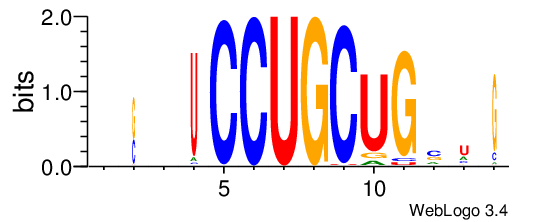

Cluster 2 (#398) quality:0.017


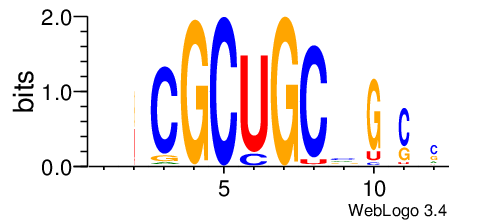

Cluster 16 (#505) quality:0.014


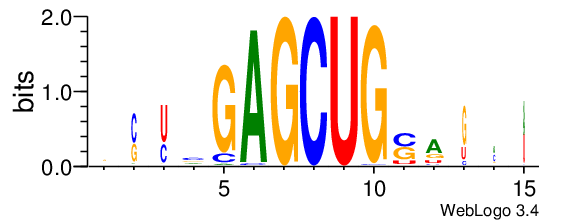

Cluster 15 (#621) quality:0.014


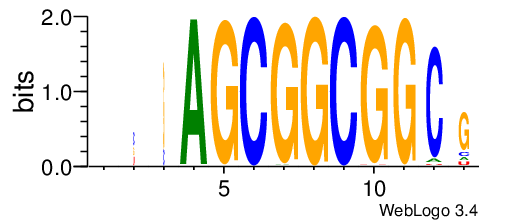

Cluster 11 (#579) quality:0.011


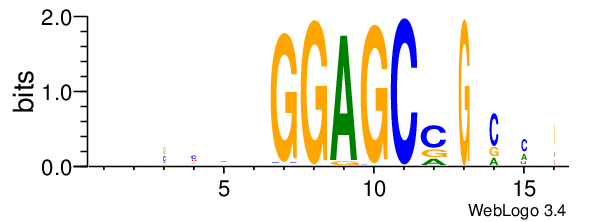

Cluster 3 (#671) quality:0.011


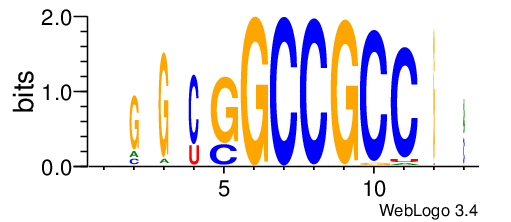

Cluster 9 (#613) quality:0.011


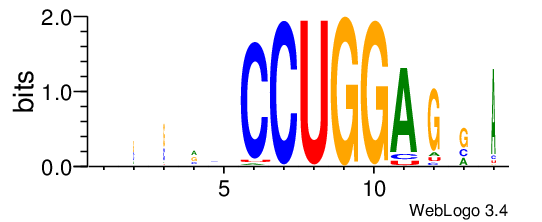

Cluster 5 (#697) quality:0.010


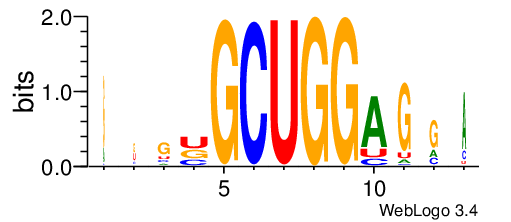

Cluster 10 (#622) quality:0.010


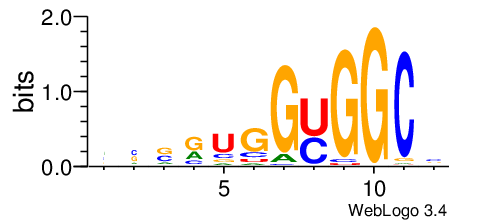

Cluster 19 (#817) quality:0.009


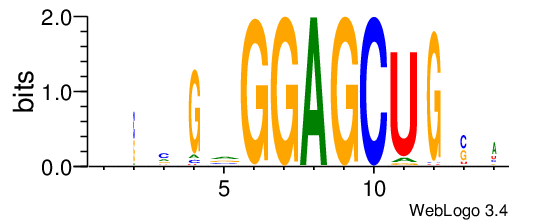

Cluster 4 (#1008) quality:0.007


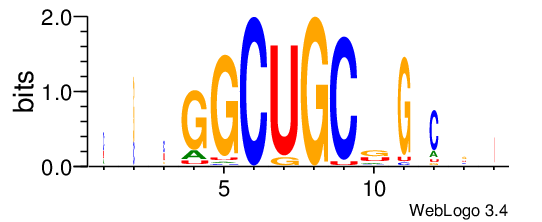

Cluster 8 (#909) quality:0.006


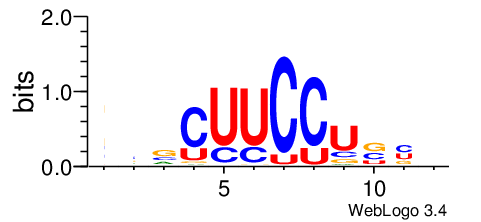

Cluster 18 (#1110) quality:0.005


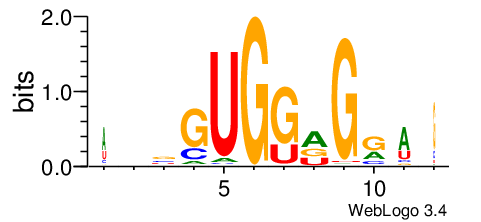

Cluster 13 (#1478) quality:0.005


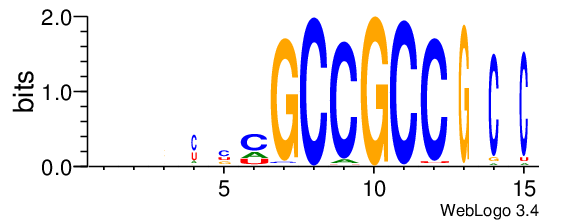

Cluster 0 (#978) quality:0.005


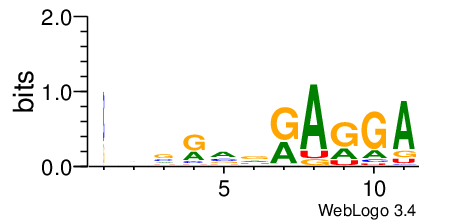

Cluster 7 (#983) quality:0.005


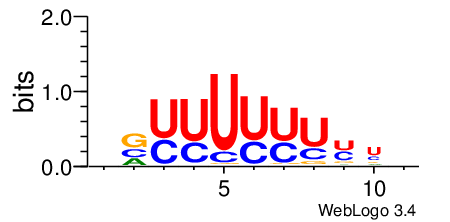

Cluster 12 (#1324) quality:0.005


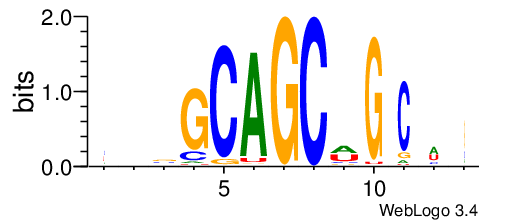

Cluster 17 (#1467) quality:0.005


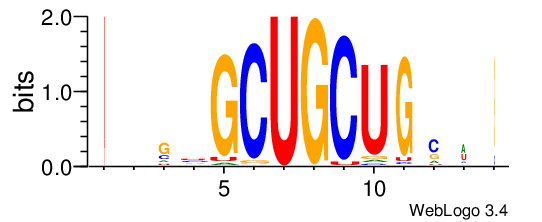

Cluster 6 (#1890) quality:0.004


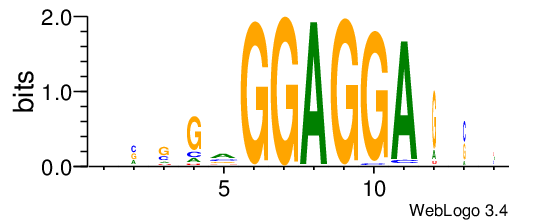

Cluster 1 (#3940) quality:0.002


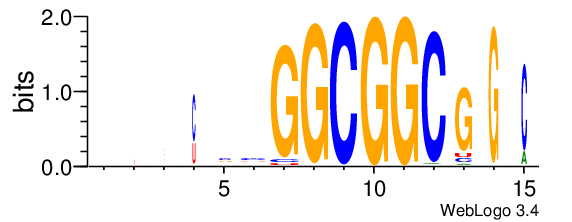

In [625]:
from eden_motif.utilities import MuscleAlignWrapper, Weblogo
from IPython.display import Image, display

#with alignment 
ma = MuscleAlignWrapper(alphabet=alphabet)
wb = Weblogo(output_format='png', sequence_type=alphabet, resolution=200, stacks_per_line=50, units='bits', color_scheme=color_scheme)

for q, cluster_id, aseqs in sorted(cluster_qualities, reverse=True):
    #for s in aseqs: print s
    if q > -100:
        logo_image = wb.create_logo(seqs=aseqs)
        print 'Cluster %d (#%d) quality:%.3f' % (cluster_id, len(aseqs),q)
        display(Image(logo_image))

---